<a href="https://colab.research.google.com/github/Gradsmith/Deep-Learning-HW3/blob/main/DL2022_HW3_P1%20(lite).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from google.colab import drive
import zipfile

try:
    import keras_cv
except:
    !pip install keras-cv
    import keras_cv

In [2]:
%load_ext tensorboard

In [3]:
# load and extract the dataset.
drive.mount('/content/drive')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Datasets/Shoe vs Sandal vs Boot Dataset.zip", 'r')
zip_ref.extractall("./data")
zip_ref.close()

drive.flush_and_unmount()

Mounted at /content/drive


# Part A)

In [4]:
batch_size = 32
img_height = 102
img_width = 136

In [5]:
data_dir = "./data/Shoe vs Sandal vs Boot Dataset/"

# split 70% for train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 15000 files belonging to 3 classes.
Using 10500 files for training.


In [6]:
# the other 30% is test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 15000 files belonging to 3 classes.
Using 4500 files for validation.


In [7]:
# get class names
class_names = train_ds.class_names

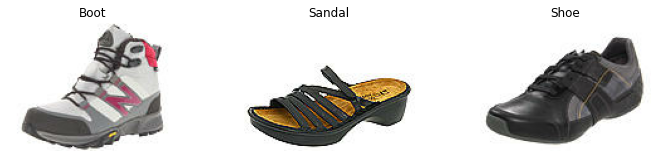

In [8]:
# show an image from each class
plt.figure(figsize=(12, 8))

for images, labels in train_ds.take(1):
    for i in range(3):
        plt.subplot(3, 3, i + 1)
        indx = np.argwhere(labels==i)[0][0]
        plt.imshow(images[indx].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

# Part B)

In [9]:
# configure the dataset for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# mlp model structure
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [11]:
# set optimizer, loss and metrics
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [12]:
# create log directory for tensorboard
log_dir = "./logs/MLP"
tensorboard = TensorBoard(log_dir=log_dir)

# train the mlp model
# note: the test data is passed as the validation argument just for
# the tensorboard plots, and it is not used as validation data.
model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
    callbacks=[tensorboard]
)

Epoch 1/10
329/329 [==============================] - 9s 23ms/step - loss: 1.5874 - sparse_categorical_accuracy: 0.6777 - val_loss: 0.8102 - val_sparse_categorical_accuracy: 0.6731
Epoch 2/10
329/329 [==============================] - 2s 6ms/step - loss: 0.7623 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.6650 - val_sparse_categorical_accuracy: 0.7691
Epoch 3/10
329/329 [==============================] - 2s 6ms/step - loss: 0.6552 - sparse_categorical_accuracy: 0.7394 - val_loss: 0.5067 - val_sparse_categorical_accuracy: 0.8333
Epoch 4/10
329/329 [==============================] - 2s 6ms/step - loss: 0.5879 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.4558 - val_sparse_categorical_accuracy: 0.8364
Epoch 5/10
329/329 [==============================] - 2s 6ms/step - loss: 0.5639 - sparse_categorical_accuracy: 0.7897 - val_loss: 0.4961 - val_sparse_categorical_accuracy: 0.8200
Epoch 6/10
329/329 [==============================] - 2s 6ms/step - loss: 0.5318 - sparse_categoric

In [13]:
# evaluate the model
y_pred_test = model.predict(test_ds).argmax(axis=1)
y_pred_train = model.predict(train_ds).argmax(axis=1)

y_true_test = np.concatenate([y for _, y in test_ds], axis=0)
y_true_train = np.concatenate([y for _, y in train_ds], axis=0)

# compute model loss and accuracy
loss_test, acc_test = model.evaluate(test_ds)
loss_train, acc_train = model.evaluate(train_ds)

# compute model precision
prc_test = precision_score(y_true_test, y_pred_test, average='macro')
prc_train = precision_score(y_true_train, y_pred_train, average='macro')

# compute model recall
rcl_test = recall_score(y_true_test, y_pred_test, average='macro')
rcl_train = recall_score(y_true_train, y_pred_train, average='macro')

329/329 [==============================] - 1s 4ms/step - loss: 0.3830 - sparse_categorical_accuracy: 0.8848


In [14]:
# print the evaluation results
print(f'Test Loss: {loss_test:.3f}, Train Loss: {loss_train:.3f}')
print(f'Test Accuracy: {acc_test*100:.3f} %, Train Accuracy: {acc_train*100:.3f} %')
print(f'Test Precision: {prc_test*100:.3f} %, Train Precision: {prc_train*100:.3f} %')
print(f'Test Recall: {rcl_test*100:.3f} %, Train Recall: {rcl_train*100:.3f} %')

Test Loss: 0.404, Train Loss: 0.383
Test Accuracy: 87.044 %, Train Accuracy: 88.476 %
Test Precision: 87.661 %, Train Precision: 88.977 %
Test Recall: 86.982 %, Train Recall: 88.513 %


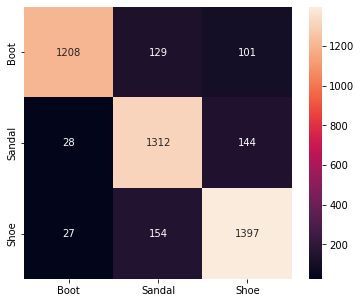

In [15]:
# plot the confusion matrix
cm = tf.math.confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(6, 5))
xticks = class_names
yticks = class_names
sns.heatmap(cm, xticklabels=xticks, yticklabels=yticks, annot=True, fmt='.0f')
plt.show()

In [16]:
# model summary and its number of parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 102, 136, 3)       0         
                                                                 
 flatten (Flatten)           (None, 41616)             0         
                                                                 
 dense (Dense)               (None, 128)               5326976   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 9

In [17]:
# save the model
model.save('./Models_P1/model_MLP.h5')

# Part C)

In [46]:
# plot loss vs epoch and accuracy vs epoch for train and test datasets
# %tensorboard --logdir logs/MLP

# Part D)

In [19]:
# cnn model structure
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [20]:
# set optimizer, loss and metrics
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [21]:
# create log directory for tensorboard
log_dir = "./logs/CNN"
tensorboard = TensorBoard(log_dir=log_dir)

# train the cnn model
model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
    callbacks=[tensorboard]
)

Epoch 1/10
329/329 [==============================] - 19s 49ms/step - loss: 0.9656 - sparse_categorical_accuracy: 0.8683 - val_loss: 82.3223 - val_sparse_categorical_accuracy: 0.3202
Epoch 2/10
329/329 [==============================] - 15s 45ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.2334 - val_sparse_categorical_accuracy: 0.9269
Epoch 3/10
329/329 [==============================] - 15s 44ms/step - loss: 0.0962 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.3546 - val_sparse_categorical_accuracy: 0.9047
Epoch 4/10
329/329 [==============================] - 15s 44ms/step - loss: 0.0575 - sparse_categorical_accuracy: 0.9790 - val_loss: 3.9986 - val_sparse_categorical_accuracy: 0.7404
Epoch 5/10
329/329 [==============================] - 15s 44ms/step - loss: 0.0418 - sparse_categorical_accuracy: 0.9868 - val_loss: 5.3101 - val_sparse_categorical_accuracy: 0.6696
Epoch 6/10
329/329 [==============================] - 15s 44ms/step - loss: 0.0563 - spar

In [22]:
# evaluate the model
y_pred_test = model.predict(test_ds).argmax(axis=1)
y_pred_train = model.predict(train_ds).argmax(axis=1)

y_true_test = np.concatenate([y for _, y in test_ds], axis=0)
y_true_train = np.concatenate([y for _, y in train_ds], axis=0)

# compute model loss and accuracy
loss_test, acc_test = model.evaluate(test_ds)
loss_train, acc_train = model.evaluate(train_ds)

# compute model precision
prc_test = precision_score(y_true_test, y_pred_test, average='macro')
prc_train = precision_score(y_true_train, y_pred_train, average='macro')

# compute model recall
rcl_test = recall_score(y_true_test, y_pred_test, average='macro')
rcl_train = recall_score(y_true_train, y_pred_train, average='macro')

329/329 [==============================] - 3s 10ms/step - loss: 0.0930 - sparse_categorical_accuracy: 0.9774


In [23]:
# print the evaluation results
print(f'Test Loss: {loss_test:.3f}, Train Loss: {loss_train:.3f}')
print(f'Test Accuracy: {acc_test*100:.3f} %, Train Accuracy: {acc_train*100:.3f} %')
print(f'Test Precision: {prc_test*100:.3f} %, Train Precision: {prc_train*100:.3f} %')
print(f'Test Recall: {rcl_test*100:.3f} %, Train Recall: {rcl_train*100:.3f} %')

Test Loss: 0.320, Train Loss: 0.093
Test Accuracy: 94.711 %, Train Accuracy: 97.743 %
Test Precision: 94.960 %, Train Precision: 97.770 %
Test Recall: 94.667 %, Train Recall: 97.755 %


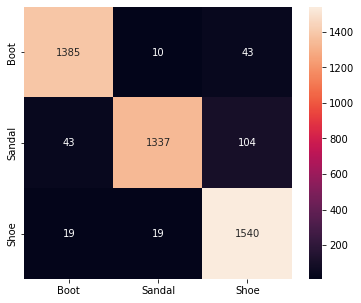

In [24]:
# plot the confusion matrix
cm = tf.math.confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(6, 5))
xticks = class_names
yticks = class_names
sns.heatmap(cm, xticklabels=xticks, yticklabels=yticks, annot=True, fmt='.0f')
plt.show()

In [25]:
# model summary and its number of parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 102, 136, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 102, 136, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 102, 136, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 102, 136, 32)     128       
 ormalization)                                                   
                                                                 
 dropout_2 (Dropout)         (None, 102, 136, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 51, 68, 32)       0         
 )                                                    

In [26]:
# save the model
model.save('./Models_P1/model_CNN.h5')

In [47]:
# plot loss vs epoch and accuracy vs epoch for train and test datasets
# %tensorboard --logdir logs/CNN

# Part E)
Despite the fact that the number of parameters in these two networks is similar, the accuracy of the CNN model is higher than that of the MLP model. Because the CNN model uses the spatial information present in images to make a prediction, whereas the MLP model does not consider this spatial structure and its input is simply a flattened tensor.

# Part F)

Since activation units in convolutional layers are spatially correlated, dropout is often less effective for convolutional layers and information can still flow through convolutional networks despite dropout. Thus, a structured form of dropout can improve the regularization of convolutional networks. DropBlock is a form of structured dropout where units in a contiguous region of a feature map are dropped together.

In [28]:
# cnn with dropblock model structure
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    keras_cv.layers.DropBlock2D(0.1, block_size=3),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    keras_cv.layers.DropBlock2D(0.1, block_size=3),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [29]:
# set optimizer, loss and metrics
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [30]:
# create log directory for tensorboard
log_dir = "./logs/CNN_DropBlock"
tensorboard = TensorBoard(log_dir=log_dir)

# train the cnn model
model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
    callbacks=[tensorboard]
)

Epoch 1/10
329/329 [==============================] - 19s 52ms/step - loss: 0.8065 - sparse_categorical_accuracy: 0.8351 - val_loss: 13.4311 - val_sparse_categorical_accuracy: 0.5656
Epoch 2/10
329/329 [==============================] - 17s 52ms/step - loss: 0.1864 - sparse_categorical_accuracy: 0.9301 - val_loss: 0.2127 - val_sparse_categorical_accuracy: 0.9304
Epoch 3/10
329/329 [==============================] - 17s 52ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.9639 - val_loss: 0.2258 - val_sparse_categorical_accuracy: 0.9269
Epoch 4/10
329/329 [==============================] - 17s 52ms/step - loss: 0.0831 - sparse_categorical_accuracy: 0.9717 - val_loss: 0.1962 - val_sparse_categorical_accuracy: 0.9467
Epoch 5/10
329/329 [==============================] - 17s 52ms/step - loss: 0.0599 - sparse_categorical_accuracy: 0.9796 - val_loss: 105.7076 - val_sparse_categorical_accuracy: 0.3344
Epoch 6/10
329/329 [==============================] - 17s 52ms/step - loss: 0.0404 - sp

In [31]:
# evaluate the model
y_pred_test = model.predict(test_ds).argmax(axis=1)
y_pred_train = model.predict(train_ds).argmax(axis=1)

y_true_test = np.concatenate([y for _, y in test_ds], axis=0)
y_true_train = np.concatenate([y for _, y in train_ds], axis=0)

# compute model loss and accuracy
loss_test, acc_test = model.evaluate(test_ds)
loss_train, acc_train = model.evaluate(train_ds)

# compute model precision
prc_test = precision_score(y_true_test, y_pred_test, average='macro')
prc_train = precision_score(y_true_train, y_pred_train, average='macro')

# compute model recall
rcl_test = recall_score(y_true_test, y_pred_test, average='macro')
rcl_train = recall_score(y_true_train, y_pred_train, average='macro')

329/329 [==============================] - 3s 10ms/step - loss: 0.0945 - sparse_categorical_accuracy: 0.9712


In [32]:
# print the evaluation results
print(f'Test Loss: {loss_test:.3f}, Train Loss: {loss_train:.3f}')
print(f'Test Accuracy: {acc_test*100:.3f} %, Train Accuracy: {acc_train*100:.3f} %')
print(f'Test Precision: {prc_test*100:.3f} %, Train Precision: {prc_train*100:.3f} %')
print(f'Test Recall: {rcl_test*100:.3f} %, Train Recall: {rcl_train*100:.3f} %')

Test Loss: 0.257, Train Loss: 0.094
Test Accuracy: 94.222 %, Train Accuracy: 97.124 %
Test Precision: 94.384 %, Train Precision: 97.246 %
Test Recall: 94.417 %, Train Recall: 97.078 %


As can be seen, adding dropblocks to our model slightly reduced its accuracy compared to the previous CNN model. This may be due to the fact that our CNN model is not large enough and thus does not require dropout and dropblock at all. (The original paper used dropblocks to improve the accuracy of the ResNet-50 model.)

Note: Sometimes the accuracy of the CNN model with dropblocks is slightly higher than that of the base CNN model. But this is not the case in my last run!

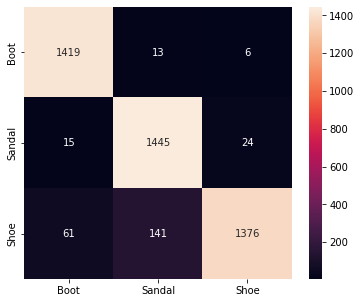

In [33]:
# plot the confusion matrix
cm = tf.math.confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(6, 5))
xticks = class_names
yticks = class_names
sns.heatmap(cm, xticklabels=xticks, yticklabels=yticks, annot=True, fmt='.0f')
plt.show()

In [34]:
# model summary and its number of parameters
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 102, 136, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 102, 136, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 102, 136, 32)      9248      
                                                                 
 batch_normalization_2 (Batc  (None, 102, 136, 32)     128       
 hNormalization)                                                 
                                                                 
 drop_block2d (DropBlock2D)  (None, 102, 136, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 51, 68, 32)       0         
 2D)                                                  

In [35]:
# save the model
model.save('./Models_P1/model_CNN_DropBlock.h5')

In [48]:
# plot loss vs epoch and accuracy vs epoch for train and test datasets
# %tensorboard --logdir logs/CNN_DropBlock

# Part G)

In [37]:
# cnn with dropblock and kernel factorization model structure
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (1, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3, 1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (1, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3, 1), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    keras_cv.layers.DropBlock2D(0.1, block_size=3),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (1, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (1, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 1), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    keras_cv.layers.DropBlock2D(0.1, block_size=3),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [38]:
# set optimizer, loss and metrics
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [39]:
# create log directory for tensorboard
log_dir = "./logs/CNN_KF"
tensorboard = TensorBoard(log_dir=log_dir)

# train the cnn model
model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
    callbacks=[tensorboard]
)

Epoch 1/10
329/329 [==============================] - 31s 87ms/step - loss: 0.6446 - sparse_categorical_accuracy: 0.8732 - val_loss: 8.7720 - val_sparse_categorical_accuracy: 0.4831
Epoch 2/10
329/329 [==============================] - 28s 84ms/step - loss: 0.1312 - sparse_categorical_accuracy: 0.9537 - val_loss: 0.2095 - val_sparse_categorical_accuracy: 0.9293
Epoch 3/10
329/329 [==============================] - 27s 83ms/step - loss: 0.0773 - sparse_categorical_accuracy: 0.9731 - val_loss: 0.6304 - val_sparse_categorical_accuracy: 0.8604
Epoch 4/10
329/329 [==============================] - 27s 83ms/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9791 - val_loss: 0.1902 - val_sparse_categorical_accuracy: 0.9438
Epoch 5/10
329/329 [==============================] - 27s 83ms/step - loss: 0.0418 - sparse_categorical_accuracy: 0.9854 - val_loss: 7.3082 - val_sparse_categorical_accuracy: 0.5616
Epoch 6/10
329/329 [==============================] - 28s 84ms/step - loss: 0.0307 - spars

In [40]:
# evaluate the model
y_pred_test = model.predict(test_ds).argmax(axis=1)
y_pred_train = model.predict(train_ds).argmax(axis=1)

y_true_test = np.concatenate([y for _, y in test_ds], axis=0)
y_true_train = np.concatenate([y for _, y in train_ds], axis=0)

# compute model loss and accuracy
loss_test, acc_test = model.evaluate(test_ds)
loss_train, acc_train = model.evaluate(train_ds)

# compute model precision
prc_test = precision_score(y_true_test, y_pred_test, average='macro')
prc_train = precision_score(y_true_train, y_pred_train, average='macro')

# compute model recall
rcl_test = recall_score(y_true_test, y_pred_test, average='macro')
rcl_train = recall_score(y_true_train, y_pred_train, average='macro')

329/329 [==============================] - 6s 19ms/step - loss: 0.1333 - sparse_categorical_accuracy: 0.9681


In [41]:
# print the evaluation results
print(f'Test Loss: {loss_test:.3f}, Train Loss: {loss_train:.3f}')
print(f'Test Accuracy: {acc_test*100:.3f} %, Train Accuracy: {acc_train*100:.3f} %')
print(f'Test Precision: {prc_test*100:.3f} %, Train Precision: {prc_train*100:.3f} %')
print(f'Test Recall: {rcl_test*100:.3f} %, Train Recall: {rcl_train*100:.3f} %')

Test Loss: 0.253, Train Loss: 0.133
Test Accuracy: 95.356 %, Train Accuracy: 96.810 %
Test Precision: 95.524 %, Train Precision: 96.966 %
Test Recall: 95.276 %, Train Recall: 96.851 %


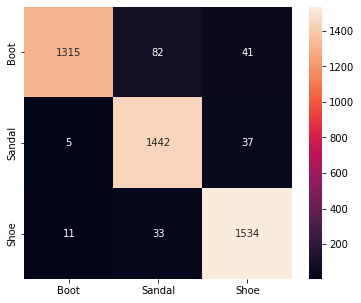

In [42]:
# plot the confusion matrix
cm = tf.math.confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(6, 5))
xticks = class_names
yticks = class_names
sns.heatmap(cm, xticklabels=xticks, yticklabels=yticks, annot=True, fmt='.0f')
plt.show()

In [43]:
# model summary and its number of parameters
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 102, 136, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 102, 136, 32)      320       
                                                                 
 conv2d_9 (Conv2D)           (None, 102, 136, 32)      3104      
                                                                 
 conv2d_10 (Conv2D)          (None, 102, 136, 32)      3104      
                                                                 
 conv2d_11 (Conv2D)          (None, 102, 136, 32)      3104      
                                                                 
 batch_normalization_4 (Batc  (None, 102, 136, 32)     128       
 hNormalization)                                                 
                                                      

As expected, the number of parameters decreased after kernel factorization compared to all the previous models (MLP and CNN).

In [44]:
# save the model
model.save('./Models_P1/model_CNN_KF.h5')

In [49]:
# plot loss vs epoch and accuracy vs epoch for train and test datasets
# %tensorboard --logdir logs/CNN_KF

Kernel factorization offers two main advantages. The first advantage is the reduced number of parameters compared to networks with non-factorized kernels, and the second advantage is the increased depth and thus increased non-linearity in the network.